# Импорты

Импорт всех необходимых библиотек

In [2]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
#from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

In [6]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [8]:
%pip install -q boruta


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [9]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [10]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

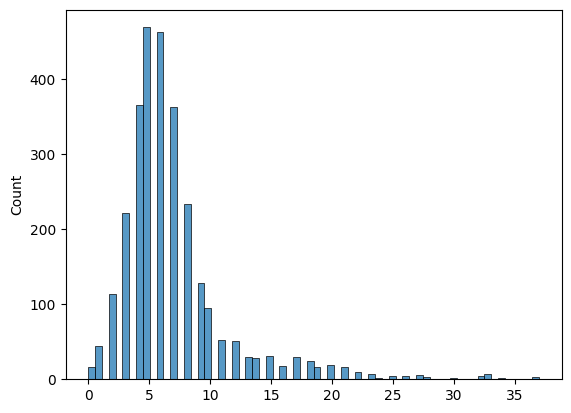

In [11]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [12]:
df = df.drop(df[df['bmi']>80].index)

In [13]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

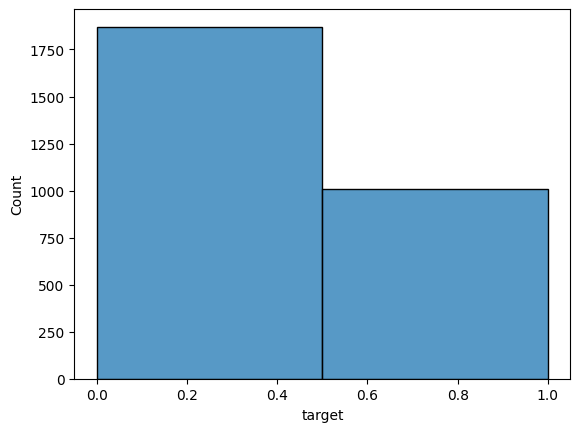

In [14]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [15]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

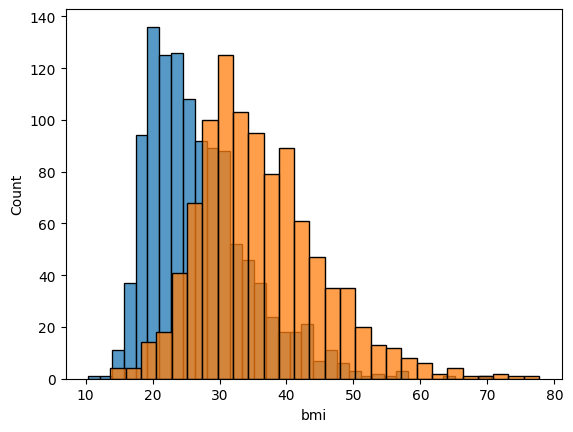

In [16]:
sns.histplot(df[df['target']==0]['bmi'], legend=True)
sns.histplot(df[df['target']==1]['bmi'], legend=True)

In [17]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_test

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
2298,NaN,NaN,NaN,552.88,61.62,4763.06,147.27,3528.20,1454.67,24.55,25.11,126.22,5.47,4.21,22.80,32.32,3755.84,127.80,2.49,167.31,1013.92,3.03,0.20,77.74,3.80,387.85,22.37,415.49,5.06,1410.47,1.96,2.16,5.21,2.17,374.71,5.67,165.95,215.47,0.04,6.38,1837.39,2.29,0.00,2.10,20.16,14.09,0.17,3.20,115.86,3.60,0.72,0.96,20.31,0.00,3.31,1.31,24.0,6.12,28.32,1.87,78.73,10.97,2.61,1.36,7.52,10.99,136.16,95.78,7.67,13.73,1,0,0,1,27.815882,0
148,NaN,NaN,NaN,863.79,23.93,658.62,9.15,929.89,881.65,NaN,14.73,73.89,5.19,4.00,6.17,8.99,1348.76,NaN,2.12,57.56,507.46,NaN,NaN,NaN,3.62,11.59,12.68,114.76,NaN,483.59,0.29,1.40,4.20,1.07,89.79,4.47,238.51,16.67,NaN,5.84,957.00,1.26,NaN,2.07,7.65,7.65,NaN,3.05,1.66,3.24,2.19,0.84,2.20,NaN,3.08,NaN,NaN,5.80,9.45,NaN,129.90,1.19,0.97,0.58,0.25,0.14,117.97,21.20,NaN,9.18,1,0,0,1,30.298684,0
2678,NaN,NaN,NaN,517.91,42.70,2848.29,114.08,2457.87,745.98,15.16,17.20,82.03,3.16,2.52,14.58,18.53,2162.62,113.46,1.34,110.19,663.58,4.32,0.10,13.99,2.26,290.53,15.53,262.74,0.87,684.07,1.05,1.44,3.44,1.24,169.83,3.29,144.77,186.00,0.02,3.70,1195.85,1.06,0.01,1.17,13.09,8.05,0.02,1.80,27.97,1.99,1.06,0.54,14.89,NaN,2.04,0.32,40.0,3.67,16.42,0.55,56.00,2.40,1.86,0.76,0.78,1.57,72.00,72.11,1.66,7.34,1,0,0,1,30.009921,0
931,NaN,38.1,NaN,131.35,8.18,1626.24,51.66,1033.55,1137.94,9.86,4.97,41.22,1.85,1.47,7.38,5.43,1272.21,52.40,0.93,32.49,175.04,NaN,0.15,3.65,1.27,150.90,4.59,147.70,1.11,178.18,0.56,0.60,1.28,0.50,127.24,2.02,22.81,31.01,0.17,2.23,503.42,0.54,NaN,0.69,8.63,3.18,0.00,1.11,19.63,1.23,0.09,0.36,6.75,NaN,1.24,0.44,NaN,2.19,9.30,1.54,20.58,3.76,2.81,0.68,1.42,1.88,30.10,18.21,0.91,4.57,1,0,0,1,34.222222,0
1728,NaN,NaN,NaN,486.51,24.67,1205.07,32.98,1958.42,1202.71,13.05,14.05,58.24,4.18,3.21,12.15,53.53,2146.39,11.82,1.69,115.38,329.80,18.22,0.15,49.68,2.89,131.48,12.42,229.86,5.80,1176.68,0.95,1.05,4.55,1.40,265.82,1.78,144.39,70.53,NaN,4.66,826.41,0.69,0.00,1.55,12.75,7.74,0.00,2.42,92.30,2.68,1.12,0.69,35.61,55.91,2.59,3.74,48.0,4.71,14.78,47.48,60.50,16.36,4.73,1.02,18.43,34.44,100.28,185.03,13.48,8.62,1,0,0,1,29.036738,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,NaN,NaN,NaN,593.58,55.01,6219.04,208.86,4025.19,2556.15,31.66,39.22,152.69,7.95,6.72,32.61,30.16,5206.21,68.06,4.00,170.54,1022.24,20.74,2.40,44.32,5.77,424.14,35.49,562.10,14.70,662.54,2.76,3.03,7.26,3.37,520.13,9.25,320.46,574.67,NaN,10.10,2201.59,5.10,NaN,3.38,29.04,18.72,0.02,5.09,231.89,5.57,1.48,1.55,19.50,48.31,5.46,2.81,NaN,9.73,36.40,345.20,293.55,9.88,11.72,2.16,20.08,50.45,215.90,186.81,14.31,15.55,0,1,0,1,31.377989,1
2454,NaN,81.1,NaN,782.11,63.56,6959.07,84.21,4331.15,2593.43,32.88,41.73,162.65,6.96,5.99,33.67,29.34,5454.11,80.82,3.68,180.76,1007.93,102.35,0.60,54.32,5.19,343.85,37.92,509.45,10.99,1183.99,3.08,2.97,7.89,3.49,480.42,7.17,370.64,31.00,0.02,9.00,2264.35,3.92,NaN,2.95,22.75,21.73,0.01,4.50,205.12,4.96,2.60,1.42,16.36,NaN,

In [18]:
df_train = df.drop(df_test.index)
df_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878,NaN,48.4,NaN,1314.46,52.61,5553.00,150.32,3520.33,1917.29,40.54,34.51,157.97,7.29,6.35,33.02,28.30,6331.41,71.30,3.59,165.20,1104.87,4.69,1.60,106.55,5.43,375.37,29.76,596.34,17.17,1675.38,3.38,3.14,9.83,4.34,617.35,10.06,485.10,274.42,0.33,9.30,2409.98,4.60,0.09,3.14,36.03,13.72,0.03,4.83,234.89,5.16,3.49,1.41,16.39,182.82,5.12,9.43,60.00,9.22,38.52,168.53,276.31,16.70,8.67,2.16,23.28,56.78,192.76,171.33,17.51,17.76,1,0,0,1,27.222051,1
2879,18.0,43.3,22.8,148.86,13.66,1495.20,46.12,981.38,792.79,10.46,8.36,30.54,1.16,0.95,8.25,10.06,1370.94,22.00,0.55,45.36,314.95,1.57,1.20,20.88,0.82,119.19,7.66,167.39,4.63,624.41,0.67,0.72,1.72,0.66,134.80,1.20,63.84,124.40,0.02,1.42,519.06,0.77,0.01,0.41,7.36,6.29,0.01,0.72,40.34,0.82,0.32,0.23,6.67,19.18,0.85,0.82,48.00,1.45,10.10,87.20,21.02,4.78,6.31,0.52,3.88,9.44,39.28,45.79,4.36,2.92,1,0,0,1,23.335466,0
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,1

In [19]:
x_train = df_train.drop(columns=['target'])
y_train = df_train['target']

In [20]:
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [21]:
column_names = x_train.columns

In [22]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

In [23]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [24]:
x_train = x_train.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,NaN,-1.252268,-1.165928,-0.852334,-1.317375,-1.055036,-1.027210,-1.116170,-1.380072,NaN,NaN,-1.380314,-0.945501,-1.174361,NaN,NaN,-1.314955,-1.034406,-0.282570,NaN,NaN,NaN,-1.102877,-1.092137,-1.186686,NaN,-0.787324,-1.071604,-1.374917,-1.246564,-1.374387,-1.159056,NaN,NaN,NaN,NaN,NaN,-1.409453,-1.102715,NaN,NaN,-1.243970,-0.955444,NaN,NaN,-0.421347,NaN,NaN,NaN,-0.868244,NaN,NaN,NaN,NaN,NaN,-1.370853,NaN,NaN,NaN,-0.882924,-1.059429,NaN,NaN,-1.402177,NaN,NaN,-1.233543,-0.916155,-0.284119,-0.467873,-0.675721,NaN
1,NaN,NaN,NaN,NaN,-1.253000,-1.166059,-0.945459,-1.349564,-0.803839,-1.042724,-1.117274,-1.384184,NaN,NaN,-1.388774,-0.947066,-1.194309,NaN,NaN,-1.316716,-1.039166,-0.336868,NaN,NaN,NaN,-1.156936,-1.093337,-1.198971,NaN,-0.790205,-1.085992,-1.367406,-1.241318,-1.389424,-1.174758,NaN,NaN,NaN,NaN,NaN,-1.417322,-1.109231,NaN,NaN,-1.260365,-0.957223,NaN,NaN,-0.502939,NaN,NaN,NaN,-0.870101,NaN,NaN,NaN,NaN,NaN,-1.362464,NaN,NaN,NaN,-0.785977,-1.059429,NaN,NaN,-1.401746,NaN,NaN,-1.235939,-0.916155,-0.284119,-0.467873,-0.675721,NaN
2,NaN,NaN,NaN,NaN,-1.252268,-1.159781,-0.867060,-1.305254,-1.187155,-1.017902,-1.116170,-1.377331,NaN,NaN,-1.361087,-0.945501,-1.183216,NaN,NaN,-1.314684,-1.027248,-0.178117,NaN,NaN,NaN,-1.101420,-1.092137,-1.176810,NaN,-0.786577,-1.064410,-1.389940,-1.249187,-1.366869,-1.207776,NaN,NaN,NaN,NaN,NaN,-1.408170,-1.102715,NaN,NaN,-1.243287,-0.955444,NaN,NaN,-0.408211,NaN,NaN,NaN,-0.868244,NaN,NaN,NaN,NaN,NaN,-1.349181,NaN,NaN,NaN,-0.998839,-1.067388,NaN,NaN,-1.400595,NaN,NaN,-1.222760,1.091519,-0.284119,-0.467873,-0.675721,NaN
3,NaN,NaN,NaN,-1.174957,-1.251536,-1.168712,NaN,-1.397864,-1.591526,NaN,-1.116722,-1.392103,-1.328210,-1.365556,-1.436457,-0.949154,-1.314439,NaN,-1.309627,-1.316310,-1.058038,NaN,NaN,NaN,-1.361372,NaN,-1.093337,-1.278358,NaN,-0.794509,-1.114767,-1.412473,-1.254433,-1.404460,-1.372689,-0.928868,-1.190234,NaN,NaN,-1.346070,-1.442591,-1.115746,NaN,-1.313487,-1.291789,-0.959892,NaN,-1.349395,NaN,-1.351322,-0.338875,-1.365376,-0.873196,NaN,-1.383084,NaN,NaN,-1.363892,-1.394621,NaN,-0.812352,NaN,-1.022022,-1.146971,NaN,NaN,-1.402752,NaN,NaN,-1.250315,-0.916155,-0.284119,-0.467873,-0.675721,NaN
4,NaN,NaN,NaN,-1.173614,-1.251902,-1.170008,NaN,-1.397435,-1.590855,NaN,-1.115618,-1.389209,-1.321618,-1.361299,-1.436457,-0.949675,-1.313128,NaN,-1.302394,-1.317935,-1.057942,NaN,NaN,NaN,-1.356547,NaN,-1.091538,-1.277635,NaN,-0.794446,-1.114767,-1.412473,-1.254433,-1.404460,-1.372340,-0.924742,-1.187670,NaN,NaN,-1.337656,-1.440673,-1.115746,NaN,-1.304834,-1.289740,-0.960782,NaN,-1.343672,NaN,-1.346180,NaN,-1.346833,-0.873196,NaN,-1.377887,NaN,NaN,-1.358089,-1.392524,NaN,-0.812264,-0.826870,-1.022022,-1.146971,NaN,NaN,-1.401458,NaN,NaN,-1.244325,-0.916155,-0.284119,-0.467873,-0.675721,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,NaN,-0.582025,NaN,2.033059,0.671568,1.167616,0.484499,0.851255,0.4

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



## Отбор признаков ADD-DEL

In [25]:
sfs = SequentialFeatureSelector(
    XGBClassifier(),  # represents the classifier
    k_features=5,
    forward=True,
    floating=True,
    scoring="f1_macro",  # means that the selection will be decided by the accuracy of the classifier.
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
)

sfs.fit(x_train, y_train)

SequentialFeatureSelector(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=XGBClassifier(base_score=None, booster=None,
                                                  callbacks=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  early_stopping_rounds=None,
                                                  enable_categorical=False,
                                                  eval_metric=None,
                                                  feature_types=None,
                                                  gamma=None, gpu_id=None,
                                                  grow_policy=None,
                                                  importance_...
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_bin=None,
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=100, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=None, ...),
                          floating=True, k_features=(5, 5), scoring='f1_macro')

In [26]:
df_temp = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
features_add_del = list(df_temp["feature_idx"].values[-1])
features_add_del

[0, 5, 15, 33, 74]

Для дальнейшей работы возьмем данные 5 наиболее значимых признаков.

In [27]:
x_train_add_del = x_train.iloc[:,features_add_del]
x_test_add_del = x_test.iloc[:,features_add_del]
x_test_add_del.columns

Index(['внутриклеточная_жидкость', 'натрий_na', 'полиненас._жир',
       'b6_пиридоксин', 'bmi'],
      dtype='object')

<Axes: ylabel='Count'>

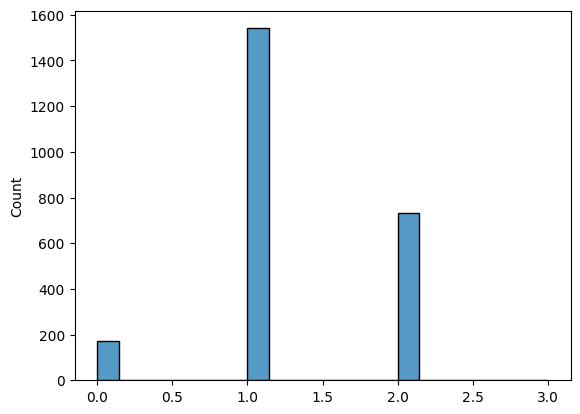

In [28]:
missing_features_add_del = x_train_add_del.isnull().sum(axis=1)
sns.histplot(missing_features_add_del)

## Отбор признаков Boruta

In [29]:
from boruta import BorutaPy

In [30]:
np.int = np.int64
np.float = np.float64
np.bool = np.bool_

In [31]:
it_imp = IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_test_imp = it_imp.transform(x_test)

In [32]:
model = XGBClassifier()
feat_selector = BorutaPy(model, n_estimators=100, verbose=1, random_state=42)
feat_selector.fit(x_train_imp, y_train)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None, gpu_id=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 n_estimators=100, n_jobs=None,
                                 num_parallel_tree=None, predictor=None,
                                 random_state=1292687486, ...),
         n_estimators=100, random_state=RandomState(MT19937) at 0x7F6B9164B240,
         verbose=1)

In [33]:
keep = x_train.columns[feat_selector.support_].to_list()
normal = x_train.columns[feat_selector.support_weak_].to_list()
drop = x_train.columns[
    ~(feat_selector.support_ | feat_selector.support_weak_)
].to_list()

print("features keep:", keep)
print("features normal:", normal)
print("features drop:", drop)

features keep: ['метионин', 'галактоза', 'метионин+цистеин', 'спорт_легкий_спорт', 'спорт_не_занимаюсь', 'bmi']
features normal: ['тощая_мт', 'профессия_работники_преимущественно_умственного_труда', 'профессия_работники_занятые_легким_физическим_трудом']
features drop: ['внутриклеточная_жидкость', 'акм', 'холестерин', 'нас._жир', 'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна', 'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир', 'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь', 'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота', 'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.', 'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин', 'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p', 'омега-3', 'лактоза', 'железо_fe', 'омега-6', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол', 'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b', 'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йо

In [34]:
keep_ind = pd.DataFrame(x_train_imp).columns[feat_selector.support_].to_list()

## Финальный набор признаков

In [35]:
result = [i for i in x_test_add_del.columns if i in keep]
result

['bmi']

In [36]:
features_selected = list(set([*keep, *x_test_add_del.columns]))
features_selected

['галактоза',
 'спорт_легкий_спорт',
 'метионин',
 'спорт_не_занимаюсь',
 'метионин+цистеин',
 'b6_пиридоксин',
 'bmi',
 'натрий_na',
 'внутриклеточная_жидкость',
 'полиненас._жир']

In [37]:
features_selected_indx = []
for i in features_selected: features_selected_indx.append(list(x_train.columns).index(i))
features_selected_indx = sorted(features_selected_indx)
features_selected_indx

[0, 5, 15, 33, 43, 46, 47, 72, 73, 74]

In [38]:
x_train_selected = x_train.iloc[:,features_selected_indx]
x_test_selected = x_test.iloc[:,features_selected_indx]

<Axes: ylabel='Count'>

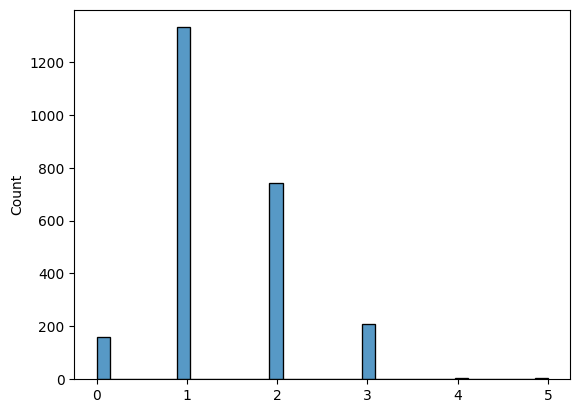

In [39]:
missing_features_selected = x_train_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

<Axes: ylabel='Count'>

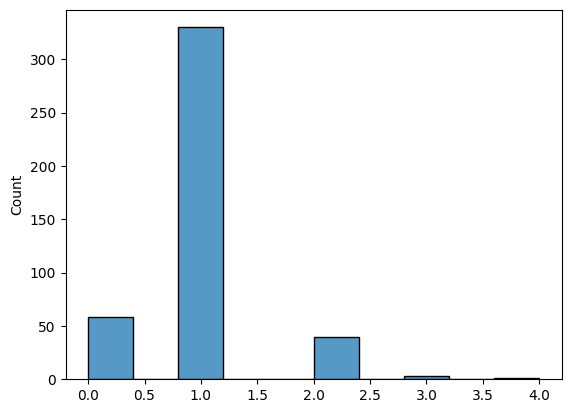

In [40]:
missing_features_selected = x_test_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

Видно, что в тренировочной и тестовой выборках с отобранными 9 параметрами, подавляющее большинство строк имеют 6 значимых признаков и более. Соответственно, на отобранных данных можн проводить обучение.

# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [101]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean')#IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_test_imp = it_imp.transform(x_test)

In [102]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [103]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-11 09:41:39,872] A new study created in memory with name: no-name-cfda44e4-cbb5-4a3b-9dd0-4f370362579e
[I 2024-11-11 09:41:48,338] Trial 0 finished with value: 0.40894568690095845 and parameters: {'max_depth': 7, 'n_estimators': 1000, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.40894568690095845.
[I 2024-11-11 09:41:53,445] Trial 1 finished with value: 0.34812286689419797 and parameters: {'max_depth': 4, 'n_estimators': 900, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.40894568690095845.
[I 2024-11-11 09:41:54,240] Trial 2 finished with value: 0.3708609271523179 and parameters: {'max_depth': 6, 'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.40894568690095845.
[I 2024-11-11 09:41:56,055] Trial 3 finished with value: 0.2783882783882784 and parameters: {'max_depth': 3, 'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with val

In [104]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 9, 'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best ROC-AUC score: 0.4299065420560747


In [105]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=9, min_samples_split=4)

Метрики, получаемые из кросс-валидации

In [106]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.79454947, 0.81447315, 0.79395628, 0.78496909, 0.79019022]),
 'score_time': array([0.02032733, 0.02038622, 0.0204289 , 0.0201087 , 0.02051926]),
 'test_accuracy': array([0.75102041, 0.78979592, 0.8244898 , 0.81836735, 0.78163265]),
 'test_precision_macro': array([0.84197947, 0.77186987, 0.80992579, 0.79203041, 0.75880088]),
 'test_recall_macro': array([0.61962036, 0.72675711, 0.77694807, 0.80509795, 0.78607802]),
 'test_f1_macro': array([0.61679487, 0.74082195, 0.7894053 , 0.79758739, 0.76537083]),
 'test_roc_auc': array([0.91516084, 0.86845655, 0.87126869, 0.84637747, 0.85772103])}

In [107]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [108]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [109]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [110]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.83      0.66       216
           1       0.65      0.32      0.43       216

    accuracy                           0.57       432
   macro avg       0.60      0.57      0.54       432
weighted avg       0.60      0.57      0.54       432

F2-score:  0.35567010309278346


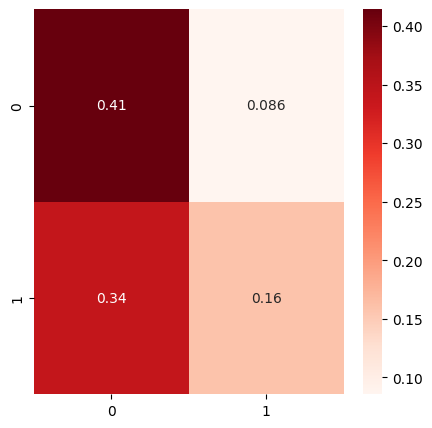

In [111]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [52]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [53]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-11 09:18:00,689] A new study created in memory with name: no-name-d51681da-7334-4480-9377-ff7ec5d4c7e3


[09:18:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:04,077] Trial 0 finished with value: 0.6255319148936169 and parameters: {'max_depth': 7, 'n_estimators': 600}. Best is trial 0 with value: 0.6255319148936169.


[09:18:04] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:04,621] Trial 1 finished with value: 0.6224899598393574 and parameters: {'max_depth': 5, 'n_estimators': 200}. Best is trial 0 with value: 0.6255319148936169.


[09:18:04] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:05,635] Trial 2 finished with value: 0.6052631578947367 and parameters: {'max_depth': 9, 'n_estimators': 100}. Best is trial 0 with value: 0.6255319148936169.


[09:18:05] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:09,648] Trial 3 finished with value: 0.6224066390041494 and parameters: {'max_depth': 6, 'n_estimators': 1000}. Best is trial 0 with value: 0.6255319148936169.


[09:18:09] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:13,408] Trial 4 finished with value: 0.6136865342163356 and parameters: {'max_depth': 10, 'n_estimators': 300}. Best is trial 0 with value: 0.6255319148936169.


[09:18:13] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:13,533] Trial 5 finished with value: 0.6278195488721805 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 5 with value: 0.6278195488721805.


[09:18:13] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:14,379] Trial 6 finished with value: 0.603448275862069 and parameters: {'max_depth': 8, 'n_estimators': 100}. Best is trial 5 with value: 0.6278195488721805.


[09:18:14] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:15,421] Trial 7 finished with value: 0.6266924564796905 and parameters: {'max_depth': 4, 'n_estimators': 600}. Best is trial 5 with value: 0.6278195488721805.


[09:18:15] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:16,525] Trial 8 finished with value: 0.6264150943396226 and parameters: {'max_depth': 3, 'n_estimators': 1000}. Best is trial 5 with value: 0.6278195488721805.


[09:18:16] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:21,359] Trial 9 finished with value: 0.6190476190476192 and parameters: {'max_depth': 8, 'n_estimators': 600}. Best is trial 5 with value: 0.6278195488721805.


[09:18:21] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:21,814] Trial 10 finished with value: 0.630188679245283 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 10 with value: 0.630188679245283.


[09:18:21] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:22,265] Trial 11 finished with value: 0.630188679245283 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 10 with value: 0.630188679245283.


[09:18:22] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:23,326] Trial 12 finished with value: 0.6275303643724696 and parameters: {'max_depth': 5, 'n_estimators': 400}. Best is trial 10 with value: 0.630188679245283.


[09:18:23] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:23,777] Trial 13 finished with value: 0.630188679245283 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 10 with value: 0.630188679245283.


[09:18:23] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:25,149] Trial 14 finished with value: 0.6242774566473989 and parameters: {'max_depth': 4, 'n_estimators': 800}. Best is trial 10 with value: 0.630188679245283.


[09:18:25] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:26,209] Trial 15 finished with value: 0.6275303643724696 and parameters: {'max_depth': 5, 'n_estimators': 400}. Best is trial 10 with value: 0.630188679245283.


[09:18:26] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:27,069] Trial 16 finished with value: 0.627906976744186 and parameters: {'max_depth': 4, 'n_estimators': 500}. Best is trial 10 with value: 0.630188679245283.


[09:18:27] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:30,233] Trial 17 finished with value: 0.6211180124223603 and parameters: {'max_depth': 6, 'n_estimators': 800}. Best is trial 10 with value: 0.630188679245283.


[09:18:30] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:30,578] Trial 18 finished with value: 0.630188679245283 and parameters: {'max_depth': 3, 'n_estimators': 300}. Best is trial 10 with value: 0.630188679245283.


[09:18:30] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:31,793] Trial 19 finished with value: 0.6254826254826256 and parameters: {'max_depth': 4, 'n_estimators': 700}. Best is trial 10 with value: 0.630188679245283.


[09:18:31] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:33,464] Trial 20 finished with value: 0.6242038216560509 and parameters: {'max_depth': 7, 'n_estimators': 300}. Best is trial 10 with value: 0.630188679245283.


[09:18:33] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:33,915] Trial 21 finished with value: 0.630188679245283 and parameters: {'max_depth': 3, 'n_estimators': 400}. Best is trial 10 with value: 0.630188679245283.


[09:18:33] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:34,472] Trial 22 finished with value: 0.6327683615819208 and parameters: {'max_depth': 3, 'n_estimators': 500}. Best is trial 22 with value: 0.6327683615819208.


[09:18:34] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:35,337] Trial 23 finished with value: 0.627906976744186 and parameters: {'max_depth': 4, 'n_estimators': 500}. Best is trial 22 with value: 0.6327683615819208.


[09:18:35] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:36,654] Trial 24 finished with value: 0.616632860040568 and parameters: {'max_depth': 5, 'n_estimators': 500}. Best is trial 22 with value: 0.6327683615819208.


[09:18:36] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:36,886] Trial 25 finished with value: 0.630188679245283 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 22 with value: 0.6327683615819208.


[09:18:36] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:38,077] Trial 26 finished with value: 0.6254826254826256 and parameters: {'max_depth': 4, 'n_estimators': 700}. Best is trial 22 with value: 0.6327683615819208.


[09:18:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:38,428] Trial 27 finished with value: 0.630188679245283 and parameters: {'max_depth': 3, 'n_estimators': 300}. Best is trial 22 with value: 0.6327683615819208.


[09:18:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:40,372] Trial 28 finished with value: 0.6198347107438016 and parameters: {'max_depth': 6, 'n_estimators': 500}. Best is trial 22 with value: 0.6327683615819208.


[09:18:40] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 09:18:42,210] Trial 29 finished with value: 0.625 and parameters: {'max_depth': 5, 'n_estimators': 700}. Best is trial 22 with value: 0.6327683615819208.


In [54]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 500}
Best f1 score: 0.6327683615819208


In [55]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train_selected, y_train)

[09:18:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=3, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=500, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [56]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())

[09:18:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[09:18:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[09:18:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[09:18:44] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[09:18:44] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [57]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.59      0.32      0.41       216
           1       0.53      0.78      0.63       216

    accuracy                           0.55       432
   macro avg       0.56      0.55      0.52       432
weighted avg       0.56      0.55      0.52       432

F2-score:  0.712468193384224


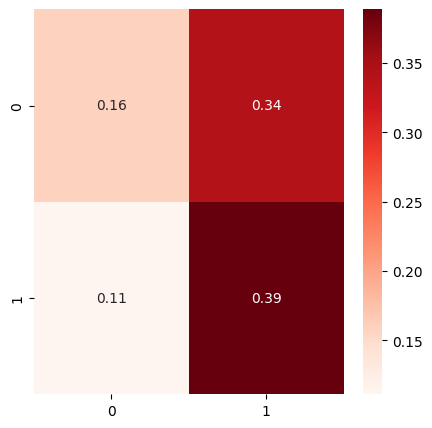

In [58]:
report(y_test, xgb_rfc_best.predict(x_test_selected))

## Бустинги

### Catboost

In [59]:
model = CatBoostClassifier(random_seed=42)

In [60]:
model.fit(
    x_train_selected,
    y_train,
    eval_set=(x_test_selected, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.03954
0:	learn: 0.6613324	test: 0.6899423	best: 0.6899423 (0)	total: 53.3ms	remaining: 53.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6715739966
bestIteration = 33

Shrink model to first 34 iterations.


In [61]:
f1_score(y_test, model.predict(x_test_selected))

0.6086956521739131

In [62]:
model.get_feature_importance(catboost.Pool(x_train_selected))

array([ 3.71391966,  3.25278276,  3.88222282,  3.26161395,  7.90461667,
        7.47509817,  3.39817519,  1.33711821,  2.71459636, 63.05985622])

In [63]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [64]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-11 09:18:46,006] A new study created in memory with name: no-name-7b88b2b9-cb0b-42f7-b222-aca741e0d29a
[I 2024-11-11 09:18:46,930] Trial 0 finished with value: 0.565947242206235 and parameters: {'learning_rate': 0.03432058914297836, 'depth': 9, 'subsample': 0.1320135288642103, 'colsample_bylevel': 0.11924731701117157, 'min_data_in_leaf': 75, 'random_strength': 0.5443397147240814}. Best is trial 0 with value: 0.565947242206235.
[I 2024-11-11 09:18:47,966] Trial 1 finished with value: 0.6164705882352942 and parameters: {'learning_rate': 0.013470400517055812, 'depth': 4, 'subsample': 0.452343933935449, 'colsample_bylevel': 0.4785747887801763, 'min_data_in_leaf': 18, 'random_strength': 1.5982328567682167}. Best is trial 1 with value: 0.6164705882352942.
[I 2024-11-11 09:18:49,398] Trial 2 finished with value: 0.5631067961165048 and parameters: {'learning_rate': 0.05779997050904315, 'depth': 6, 'subsample': 0.7941282556346696, 'colsample_bylevel': 0.8977103549151357, 'min_data_in

In [65]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.013470400517055812, 'depth': 4, 'subsample': 0.452343933935449, 'colsample_bylevel': 0.4785747887801763, 'min_data_in_leaf': 18, 'random_strength': 1.5982328567682167}
Best f1 score: 0.6164705882352942


In [66]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train_selected, y_train)

0:	learn: 0.6836742	total: 1.16ms	remaining: 1.16s
1:	learn: 0.6747164	total: 2.36ms	remaining: 1.18s
2:	learn: 0.6664183	total: 3.35ms	remaining: 1.11s
3:	learn: 0.6578501	total: 4.37ms	remaining: 1.09s
4:	learn: 0.6497910	total: 5.4ms	remaining: 1.07s
5:	learn: 0.6419022	total: 6.42ms	remaining: 1.06s
6:	learn: 0.6340579	total: 7.39ms	remaining: 1.05s
7:	learn: 0.6265400	total: 8.35ms	remaining: 1.03s
8:	learn: 0.6194126	total: 9.26ms	remaining: 1.02s
9:	learn: 0.6138244	total: 10.2ms	remaining: 1.01s
10:	learn: 0.6070495	total: 11.2ms	remaining: 1.01s
11:	learn: 0.6016235	total: 12.1ms	remaining: 996ms
12:	learn: 0.5950403	total: 13.1ms	remaining: 996ms
13:	learn: 0.5887671	total: 14.1ms	remaining: 994ms
14:	learn: 0.5864164	total: 15.1ms	remaining: 993ms
15:	learn: 0.5815786	total: 16.1ms	remaining: 990ms
16:	learn: 0.5762916	total: 17ms	remaining: 985ms
17:	learn: 0.5719336	total: 18ms	remaining: 982ms
18:	learn: 0.5662732	total: 19ms	remaining: 979ms
19:	learn: 0.5615619	total: 1

In [67]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6858705	total: 833us	remaining: 832ms
1:	learn: 0.6770029	total: 1.84ms	remaining: 918ms
2:	learn: 0.6688804	total: 2.71ms	remaining: 902ms
3:	learn: 0.6604487	total: 3.58ms	remaining: 892ms
4:	learn: 0.6523832	total: 4.5ms	remaining: 896ms
5:	learn: 0.6452610	total: 5.4ms	remaining: 895ms
6:	learn: 0.6385479	total: 6.27ms	remaining: 890ms
7:	learn: 0.6304427	total: 7.16ms	remaining: 888ms
8:	learn: 0.6233927	total: 7.92ms	remaining: 873ms
9:	learn: 0.6178018	total: 8.64ms	remaining: 855ms
10:	learn: 0.6116948	total: 9.51ms	remaining: 855ms
11:	learn: 0.6062986	total: 10.3ms	remaining: 850ms
12:	learn: 0.6001626	total: 11.2ms	remaining: 848ms
13:	learn: 0.5940627	total: 12ms	remaining: 846ms
14:	learn: 0.5914753	total: 12.9ms	remaining: 846ms
15:	learn: 0.5867147	total: 13.8ms	remaining: 850ms
16:	learn: 0.5812693	total: 14.6ms	remaining: 846ms
17:	learn: 0.5769762	total: 15.6ms	remaining: 852ms
18:	learn: 0.5711545	total: 16.5ms	remaining: 851ms
19:	learn: 0.5664903	total:

{'fit_time': array([0.9360826 , 0.94262791, 0.93723774, 0.92939711, 0.94560552]),
 'score_time': array([0.00815582, 0.0077107 , 0.00670505, 0.0086906 , 0.00787711]),
 'test_accuracy': array([0.84489796, 0.84897959, 0.82040816, 0.80408163, 0.75306122]),
 'test_precision_macro': array([0.87981346, 0.82775656, 0.79467552, 0.77811899, 0.74958333]),
 'test_recall_macro': array([0.77081077, 0.82775656, 0.79843812, 0.79942617, 0.78453894]),
 'test_f1_macro': array([0.7980521 , 0.82775656, 0.79648474, 0.7855619 , 0.74424012]),
 'test_roc_auc': array([0.9469114 , 0.91194969, 0.89129567, 0.86952061, 0.84675749])}

In [68]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.61      0.61      0.61       216
           1       0.61      0.61      0.61       216

    accuracy                           0.61       432
   macro avg       0.61      0.61      0.61       432
weighted avg       0.61      0.61      0.61       432

F2-score:  0.6064814814814815


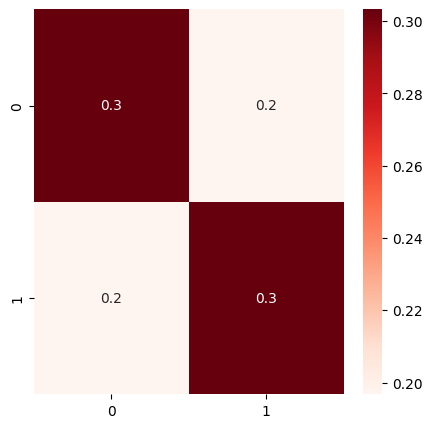

In [69]:
report(y_test, cb_best.predict(x_test_selected))

### XGBoost

In [70]:
model = XGBClassifier()

In [71]:
model.fit(
    x_train_selected,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [72]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [73]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-11 09:19:42,540] A new study created in memory with name: no-name-870729c4-ee32-4000-ab6c-b6cf20792252


[09:19:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:19:48,195] Trial 0 finished with value: 0.606896551724138 and parameters: {'learning_rate': 0.001304624833448253, 'max_depth': 361, 'n_estimators': 800, 'subsample': 0.40390066587352097, 'colsample_bylevel': 0.6062744777975906, 'gamma': 1.186064843735738}. Best is trial 0 with value: 0.606896551724138.


[09:19:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:19:50,896] Trial 1 finished with value: 0.5651105651105651 and parameters: {'learning_rate': 0.03451875642176966, 'max_depth': 106, 'n_estimators': 500, 'subsample': 0.8541919202534684, 'colsample_bylevel': 0.19488589205086942, 'gamma': 0.5652983808954156}. Best is trial 0 with value: 0.606896551724138.


[09:19:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:19:51,596] Trial 2 finished with value: 0.5495049504950495 and parameters: {'learning_rate': 0.002039581294947683, 'max_depth': 263, 'n_estimators': 300, 'subsample': 0.09553449167137075, 'colsample_bylevel': 0.48864010612030484, 'gamma': 2.6034390585934917}. Best is trial 0 with value: 0.606896551724138.


[09:19:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:19:52,310] Trial 3 finished with value: 0.5892857142857143 and parameters: {'learning_rate': 0.0012755016523298562, 'max_depth': 223, 'n_estimators': 100, 'subsample': 0.4539574948293927, 'colsample_bylevel': 0.9488103183085835, 'gamma': 0.8188308112542819}. Best is trial 0 with value: 0.606896551724138.


[09:19:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:19:57,977] Trial 4 finished with value: 0.6157407407407407 and parameters: {'learning_rate': 0.0035767863204873612, 'max_depth': 135, 'n_estimators': 800, 'subsample': 0.3647022665535532, 'colsample_bylevel': 0.7359412230329219, 'gamma': 1.608604175525952}. Best is trial 4 with value: 0.6157407407407407.


[09:19:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:19:59,984] Trial 5 finished with value: 0.609090909090909 and parameters: {'learning_rate': 0.023616206627648628, 'max_depth': 344, 'n_estimators': 1000, 'subsample': 0.07590230415478308, 'colsample_bylevel': 0.7160632813263306, 'gamma': 1.6838098098522734}. Best is trial 4 with value: 0.6157407407407407.


[09:19:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:06,008] Trial 6 finished with value: 0.6157407407407407 and parameters: {'learning_rate': 0.0017787217957067345, 'max_depth': 171, 'n_estimators': 800, 'subsample': 0.42358185484846245, 'colsample_bylevel': 0.4128216715352481, 'gamma': 2.870429434853433}. Best is trial 4 with value: 0.6157407407407407.


[09:20:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:09,435] Trial 7 finished with value: 0.6153846153846153 and parameters: {'learning_rate': 0.0018369201531892754, 'max_depth': 341, 'n_estimators': 300, 'subsample': 0.9713642650096822, 'colsample_bylevel': 0.25929081138198334, 'gamma': 2.2136725784526528}. Best is trial 4 with value: 0.6157407407407407.


[09:20:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:10,220] Trial 8 finished with value: 0.5651105651105651 and parameters: {'learning_rate': 0.012557886557046411, 'max_depth': 102, 'n_estimators': 200, 'subsample': 0.41428827032465504, 'colsample_bylevel': 0.17219520936589983, 'gamma': 1.8438728379883589}. Best is trial 4 with value: 0.6157407407407407.


[09:20:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:17,233] Trial 9 finished with value: 0.5493975903614459 and parameters: {'learning_rate': 0.05863496757187112, 'max_depth': 182, 'n_estimators': 700, 'subsample': 0.6318652259097279, 'colsample_bylevel': 0.7224315016575534, 'gamma': 2.571927746029383}. Best is trial 4 with value: 0.6157407407407407.


[09:20:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:27,873] Trial 10 finished with value: 0.6018518518518519 and parameters: {'learning_rate': 0.004977831755558095, 'max_depth': 481, 'n_estimators': 1000, 'subsample': 0.6214895674762407, 'colsample_bylevel': 0.9799069154262947, 'gamma': 0.1336057166111051}. Best is trial 4 with value: 0.6157407407407407.


[09:20:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:31,533] Trial 11 finished with value: 0.6070588235294118 and parameters: {'learning_rate': 0.004646142540436777, 'max_depth': 175, 'n_estimators': 700, 'subsample': 0.2545148157284399, 'colsample_bylevel': 0.4084860172574863, 'gamma': 2.8033393268501676}. Best is trial 4 with value: 0.6157407407407407.


[09:20:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:35,884] Trial 12 finished with value: 0.6100917431192661 and parameters: {'learning_rate': 0.0042782223162618465, 'max_depth': 167, 'n_estimators': 800, 'subsample': 0.2658814949098999, 'colsample_bylevel': 0.7860623463695803, 'gamma': 2.1075607064386723}. Best is trial 4 with value: 0.6157407407407407.


[09:20:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:40,648] Trial 13 finished with value: 0.6214953271028036 and parameters: {'learning_rate': 0.0030272545111706644, 'max_depth': 260, 'n_estimators': 500, 'subsample': 0.5862100867597123, 'colsample_bylevel': 0.38874766006309514, 'gamma': 1.3113993821690884}. Best is trial 13 with value: 0.6214953271028036.


[09:20:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:46,440] Trial 14 finished with value: 0.602803738317757 and parameters: {'learning_rate': 0.009125293167800254, 'max_depth': 450, 'n_estimators': 500, 'subsample': 0.682652013266766, 'colsample_bylevel': 0.5790223608192178, 'gamma': 1.3036180169262757}. Best is trial 13 with value: 0.6214953271028036.


[09:20:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:53,724] Trial 15 finished with value: 0.616822429906542 and parameters: {'learning_rate': 0.0031969391584321426, 'max_depth': 271, 'n_estimators': 600, 'subsample': 0.7729662486037014, 'colsample_bylevel': 0.32650387568112144, 'gamma': 1.1935896856698636}. Best is trial 13 with value: 0.6214953271028036.


[09:20:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:20:55,909] Trial 16 finished with value: 0.5783132530120482 and parameters: {'learning_rate': 0.009475376556844288, 'max_depth': 286, 'n_estimators': 400, 'subsample': 0.7753125255477444, 'colsample_bylevel': 0.08018655224031773, 'gamma': 0.9493110709568122}. Best is trial 13 with value: 0.6214953271028036.


[09:20:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:03,315] Trial 17 finished with value: 0.6129032258064516 and parameters: {'learning_rate': 0.0025175648055879895, 'max_depth': 247, 'n_estimators': 600, 'subsample': 0.8011686266576734, 'colsample_bylevel': 0.3181179209601055, 'gamma': 0.47227713998369103}. Best is trial 13 with value: 0.6214953271028036.


[09:21:03] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:08,326] Trial 18 finished with value: 0.6121495327102804 and parameters: {'learning_rate': 0.0010046395126461225, 'max_depth': 319, 'n_estimators': 600, 'subsample': 0.5579214305276202, 'colsample_bylevel': 0.35241114635630755, 'gamma': 1.292914861469717}. Best is trial 13 with value: 0.6214953271028036.


[09:21:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:10,914] Trial 19 finished with value: 0.6062052505966588 and parameters: {'learning_rate': 0.00805413113320564, 'max_depth': 400, 'n_estimators': 400, 'subsample': 0.9719828425324589, 'colsample_bylevel': 0.06629338430461779, 'gamma': 0.9992415981032654}. Best is trial 13 with value: 0.6214953271028036.


[09:21:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:16,723] Trial 20 finished with value: 0.6004618937644342 and parameters: {'learning_rate': 0.014762281586482958, 'max_depth': 223, 'n_estimators': 400, 'subsample': 0.8706434018541277, 'colsample_bylevel': 0.47836036330405485, 'gamma': 2.064934669734338}. Best is trial 13 with value: 0.6214953271028036.


[09:21:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:22,022] Trial 21 finished with value: 0.5898617511520737 and parameters: {'learning_rate': 0.0032754124226910815, 'max_depth': 291, 'n_estimators': 900, 'subsample': 0.29079046333614145, 'colsample_bylevel': 0.858671510268355, 'gamma': 1.513440728255194}. Best is trial 13 with value: 0.6214953271028036.


[09:21:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:28,676] Trial 22 finished with value: 0.6082949308755761 and parameters: {'learning_rate': 0.006129601504042719, 'max_depth': 140, 'n_estimators': 700, 'subsample': 0.5270927464905275, 'colsample_bylevel': 0.5282930222802558, 'gamma': 1.5242656529570715}. Best is trial 13 with value: 0.6214953271028036.


[09:21:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:35,665] Trial 23 finished with value: 0.6018518518518519 and parameters: {'learning_rate': 0.003199434653328248, 'max_depth': 225, 'n_estimators': 600, 'subsample': 0.6952555991592446, 'colsample_bylevel': 0.6570262587158534, 'gamma': 1.8271182205551282}. Best is trial 13 with value: 0.6214953271028036.


[09:21:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:41,124] Trial 24 finished with value: 0.6086956521739131 and parameters: {'learning_rate': 0.0031441394441548477, 'max_depth': 398, 'n_estimators': 900, 'subsample': 0.3520280756905675, 'colsample_bylevel': 0.24986500032284842, 'gamma': 0.755531951270495}. Best is trial 13 with value: 0.6214953271028036.


[09:21:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:42,978] Trial 25 finished with value: 0.6124401913875598 and parameters: {'learning_rate': 0.006049809352964338, 'max_depth': 199, 'n_estimators': 500, 'subsample': 0.1613556363579128, 'colsample_bylevel': 0.44467984168942065, 'gamma': 1.1698059433052426}. Best is trial 13 with value: 0.6214953271028036.


[09:21:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:49,658] Trial 26 finished with value: 0.619718309859155 and parameters: {'learning_rate': 0.0027966603346312293, 'max_depth': 272, 'n_estimators': 700, 'subsample': 0.5743932048334964, 'colsample_bylevel': 0.33303410786065885, 'gamma': 1.4424919158570932}. Best is trial 13 with value: 0.6214953271028036.


[09:21:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:55,083] Trial 27 finished with value: 0.5437352245862885 and parameters: {'learning_rate': 0.09683964260922194, 'max_depth': 259, 'n_estimators': 600, 'subsample': 0.7415428392142845, 'colsample_bylevel': 0.31854580597797405, 'gamma': 1.3645212231849382}. Best is trial 13 with value: 0.6214953271028036.


[09:21:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:21:58,178] Trial 28 finished with value: 0.5398457583547558 and parameters: {'learning_rate': 0.0025261856438936296, 'max_depth': 307, 'n_estimators': 700, 'subsample': 0.5631390645171817, 'colsample_bylevel': 0.19485863719941166, 'gamma': 1.0444480874539022}. Best is trial 13 with value: 0.6214953271028036.


[09:21:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:22:01,975] Trial 29 finished with value: 0.6103286384976526 and parameters: {'learning_rate': 0.0014451977427879785, 'max_depth': 383, 'n_estimators': 500, 'subsample': 0.47660121380094767, 'colsample_bylevel': 0.3880519886267241, 'gamma': 1.8466855971096883}. Best is trial 13 with value: 0.6214953271028036.


In [74]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.0030272545111706644, 'max_depth': 260, 'n_estimators': 500, 'subsample': 0.5862100867597123, 'colsample_bylevel': 0.38874766006309514, 'gamma': 1.3113993821690884}
Best f1 score: 0.6214953271028036


In [75]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train_selected, y_train)

[09:22:02] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.38874766006309514, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.3113993821690884, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0030272545111706644, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=260, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [76]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

[09:22:06] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:22:10] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:22:14] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:22:18] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:22:22] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([3.8578074 , 4.04377627, 3.93826652, 3.82449913, 3.60080051]),
 'score_time': array([0.01401711, 0.01353168, 0.0134201 , 0.01322198, 0.01381826]),
 'test_accuracy': array([0.8122449 , 0.84081633, 0.82857143, 0.79591837, 0.75306122]),
 'test_precision_macro': array([0.86220559, 0.81945113, 0.80363636, 0.77036894, 0.74322742]),
 'test_recall_macro': array([0.71886222, 0.81517794, 0.80938266, 0.79338388, 0.77636854]),
 'test_f1_macro': array([0.74325679, 0.81723762, 0.80634598, 0.77777778, 0.74210414]),
 'test_roc_auc': array([0.94335822, 0.91265272, 0.88713447, 0.86632845, 0.83792206])}

In [77]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.62      0.63      0.63       216
           1       0.63      0.62      0.62       216

    accuracy                           0.62       432
   macro avg       0.63      0.62      0.62       432
weighted avg       0.63      0.62      0.62       432

F2-score:  0.6180297397769515


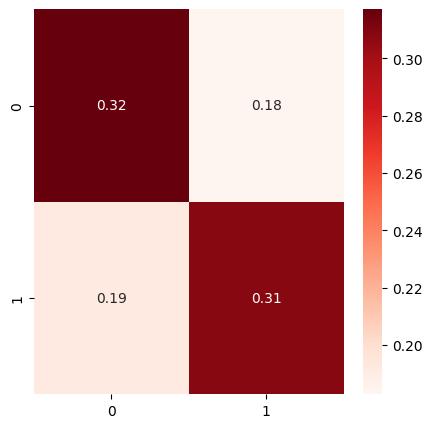

In [78]:
report(y_test, xgb_best.predict(x_test_selected))

### LightGBM

In [79]:
model = LGBMClassifier()

In [80]:
model.fit(
    x_train_selected,
    y_train,
    )

LGBMClassifier()

In [81]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [82]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-11 09:22:26,570] A new study created in memory with name: no-name-3a473d70-ff22-496d-a27a-bdb00e08378d


[09:22:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:22:30,486] Trial 0 finished with value: 0.5815602836879432 and parameters: {'learning_rate': 0.01968165120488171, 'max_depth': 412, 'n_estimators': 400, 'subsample': 0.5500123144056116, 'colsample_bylevel': 0.624976888826813, 'gamma': 2.1187317615863805}. Best is trial 0 with value: 0.5815602836879432.


[09:22:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:22:36,824] Trial 1 finished with value: 0.577367205542725 and parameters: {'learning_rate': 0.013198014056628998, 'max_depth': 220, 'n_estimators': 500, 'subsample': 0.7533072938028892, 'colsample_bylevel': 0.9658008006691439, 'gamma': 1.1488634688574708}. Best is trial 0 with value: 0.5815602836879432.


[09:22:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:22:40,641] Trial 2 finished with value: 0.5815602836879432 and parameters: {'learning_rate': 0.04393903190298412, 'max_depth': 432, 'n_estimators': 600, 'subsample': 0.3855152737704092, 'colsample_bylevel': 0.6366143659611092, 'gamma': 1.6749242903061825}. Best is trial 0 with value: 0.5815602836879432.


[09:22:40] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:22:46,878] Trial 3 finished with value: 0.6049661399548533 and parameters: {'learning_rate': 0.0025802996156306848, 'max_depth': 327, 'n_estimators': 900, 'subsample': 0.355495001893933, 'colsample_bylevel': 0.7473174123681064, 'gamma': 0.7805387921216533}. Best is trial 3 with value: 0.6049661399548533.


[09:22:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:22:48,859] Trial 4 finished with value: 0.5625 and parameters: {'learning_rate': 0.034722394922337675, 'max_depth': 383, 'n_estimators': 700, 'subsample': 0.11957610277944732, 'colsample_bylevel': 0.8891682642675136, 'gamma': 2.6568765916047976}. Best is trial 3 with value: 0.6049661399548533.


[09:22:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:22:59,736] Trial 5 finished with value: 0.5879518072289157 and parameters: {'learning_rate': 0.00843090810015945, 'max_depth': 320, 'n_estimators': 1000, 'subsample': 0.7530026493269938, 'colsample_bylevel': 0.28700136663718095, 'gamma': 0.9623466010220856}. Best is trial 3 with value: 0.6049661399548533.


[09:22:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:23:00,392] Trial 6 finished with value: 0.5550239234449761 and parameters: {'learning_rate': 0.08081704417535569, 'max_depth': 285, 'n_estimators': 200, 'subsample': 0.2872139314750193, 'colsample_bylevel': 0.1685560959760553, 'gamma': 2.6045057722475797}. Best is trial 3 with value: 0.6049661399548533.


[09:23:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:23:01,152] Trial 7 finished with value: 0.5754716981132075 and parameters: {'learning_rate': 0.005923167913080086, 'max_depth': 373, 'n_estimators': 300, 'subsample': 0.09483363419999809, 'colsample_bylevel': 0.595851789797483, 'gamma': 1.167078774695832}. Best is trial 3 with value: 0.6049661399548533.


[09:23:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:23:02,871] Trial 8 finished with value: 0.5785876993166287 and parameters: {'learning_rate': 0.02348375375331306, 'max_depth': 263, 'n_estimators': 200, 'subsample': 0.44581599391679017, 'colsample_bylevel': 0.8092146875978484, 'gamma': 2.7058252279466832}. Best is trial 3 with value: 0.6049661399548533.


[09:23:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:23:07,293] Trial 9 finished with value: 0.589622641509434 and parameters: {'learning_rate': 0.049723523138364714, 'max_depth': 272, 'n_estimators': 500, 'subsample': 0.7820779111427109, 'colsample_bylevel': 0.500917750888889, 'gamma': 0.38526506702799823}. Best is trial 3 with value: 0.6049661399548533.


[09:23:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:23:21,868] Trial 10 finished with value: 0.6013986013986014 and parameters: {'learning_rate': 0.0014997010352098238, 'max_depth': 132, 'n_estimators': 1000, 'subsample': 0.978506017688479, 'colsample_bylevel': 0.348130237431733, 'gamma': 0.2607127873753933}. Best is trial 3 with value: 0.6049661399548533.


[09:23:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:23:35,739] Trial 11 finished with value: 0.6023529411764705 and parameters: {'learning_rate': 0.0016348446869323342, 'max_depth': 109, 'n_estimators': 1000, 'subsample': 0.9107825375392233, 'colsample_bylevel': 0.3840960866589808, 'gamma': 0.19246217975157082}. Best is trial 3 with value: 0.6049661399548533.


[09:23:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:23:43,409] Trial 12 finished with value: 0.6221198156682027 and parameters: {'learning_rate': 0.0012278875920198962, 'max_depth': 138, 'n_estimators': 800, 'subsample': 0.6035269986002088, 'colsample_bylevel': 0.4288255656496961, 'gamma': 0.6178314747346527}. Best is trial 12 with value: 0.6221198156682027.


[09:23:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:23:52,046] Trial 13 finished with value: 0.605080831408776 and parameters: {'learning_rate': 0.003511851423380288, 'max_depth': 499, 'n_estimators': 800, 'subsample': 0.6038113737356945, 'colsample_bylevel': 0.7832524985038619, 'gamma': 0.6957156486782046}. Best is trial 12 with value: 0.6221198156682027.


[09:23:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:23:56,068] Trial 14 finished with value: 0.5784313725490196 and parameters: {'learning_rate': 0.004215917729032351, 'max_depth': 473, 'n_estimators': 800, 'subsample': 0.6199487254823248, 'colsample_bylevel': 0.11989099429467304, 'gamma': 0.5909505190695924}. Best is trial 12 with value: 0.6221198156682027.


[09:23:56] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:24:04,102] Trial 15 finished with value: 0.6104783599088838 and parameters: {'learning_rate': 0.0010202579052015954, 'max_depth': 169, 'n_estimators': 800, 'subsample': 0.6361492084672051, 'colsample_bylevel': 0.46633916778544476, 'gamma': 1.5422940586569038}. Best is trial 12 with value: 0.6221198156682027.


[09:24:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:24:11,030] Trial 16 finished with value: 0.6195899772209567 and parameters: {'learning_rate': 0.0010119894987918347, 'max_depth': 181, 'n_estimators': 700, 'subsample': 0.6470232134860672, 'colsample_bylevel': 0.45806682378911, 'gamma': 1.587767684923584}. Best is trial 12 with value: 0.6221198156682027.


[09:24:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:24:18,110] Trial 17 finished with value: 0.617169373549884 and parameters: {'learning_rate': 0.0010344258555051481, 'max_depth': 194, 'n_estimators': 600, 'subsample': 0.8441952983859791, 'colsample_bylevel': 0.31653994226726223, 'gamma': 1.694366052716884}. Best is trial 12 with value: 0.6221198156682027.


[09:24:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:24:23,412] Trial 18 finished with value: 0.6172248803827751 and parameters: {'learning_rate': 0.001856353784919429, 'max_depth': 150, 'n_estimators': 700, 'subsample': 0.49880967121964964, 'colsample_bylevel': 0.21081206274144956, 'gamma': 2.156042593398438}. Best is trial 12 with value: 0.6221198156682027.


[09:24:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:24:25,358] Trial 19 finished with value: 0.49056603773584906 and parameters: {'learning_rate': 0.0023530961412582393, 'max_depth': 224, 'n_estimators': 700, 'subsample': 0.23064442541001595, 'colsample_bylevel': 0.05933398052940653, 'gamma': 1.4371604107484692}. Best is trial 12 with value: 0.6221198156682027.


[09:24:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:24:36,125] Trial 20 finished with value: 0.5879629629629629 and parameters: {'learning_rate': 0.005206101810084822, 'max_depth': 107, 'n_estimators': 900, 'subsample': 0.68839788587705, 'colsample_bylevel': 0.4269936398200402, 'gamma': 2.0250501021597507}. Best is trial 12 with value: 0.6221198156682027.


[09:24:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:24:41,270] Trial 21 finished with value: 0.5975903614457831 and parameters: {'learning_rate': 0.0017254953720746995, 'max_depth': 171, 'n_estimators': 700, 'subsample': 0.4826403635195269, 'colsample_bylevel': 0.21398359818977503, 'gamma': 2.0431221682313048}. Best is trial 12 with value: 0.6221198156682027.


[09:24:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:24:46,991] Trial 22 finished with value: 0.6086956521739131 and parameters: {'learning_rate': 0.0025736214531079655, 'max_depth': 148, 'n_estimators': 700, 'subsample': 0.5222379573443696, 'colsample_bylevel': 0.24054131729794223, 'gamma': 2.3498032505040864}. Best is trial 12 with value: 0.6221198156682027.


[09:24:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:24:53,355] Trial 23 finished with value: 0.6118721461187215 and parameters: {'learning_rate': 0.0013200381331255338, 'max_depth': 219, 'n_estimators': 600, 'subsample': 0.6800472051194927, 'colsample_bylevel': 0.5387207346510052, 'gamma': 2.940225252137581}. Best is trial 12 with value: 0.6221198156682027.


[09:24:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:25:00,231] Trial 24 finished with value: 0.6270022883295194 and parameters: {'learning_rate': 0.00206976891372524, 'max_depth': 143, 'n_estimators': 900, 'subsample': 0.41853987848921637, 'colsample_bylevel': 0.41151002085841937, 'gamma': 1.7977245904671344}. Best is trial 24 with value: 0.6270022883295194.


[09:25:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:25:05,274] Trial 25 finished with value: 0.6139534883720931 and parameters: {'learning_rate': 0.0010061716003012086, 'max_depth': 190, 'n_estimators': 800, 'subsample': 0.3666390800933099, 'colsample_bylevel': 0.41313236312192025, 'gamma': 1.3446360276588527}. Best is trial 24 with value: 0.6270022883295194.


[09:25:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:25:14,421] Trial 26 finished with value: 0.6064814814814815 and parameters: {'learning_rate': 0.00308982343970792, 'max_depth': 126, 'n_estimators': 900, 'subsample': 0.5677778386399258, 'colsample_bylevel': 0.5523810692120324, 'gamma': 1.8407685029216971}. Best is trial 24 with value: 0.6270022883295194.


[09:25:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:25:21,619] Trial 27 finished with value: 0.5874125874125875 and parameters: {'learning_rate': 0.007827191488667392, 'max_depth': 193, 'n_estimators': 900, 'subsample': 0.43070918929751234, 'colsample_bylevel': 0.6871042634192206, 'gamma': 1.1492139307695208}. Best is trial 24 with value: 0.6270022883295194.


[09:25:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:25:30,983] Trial 28 finished with value: 0.6129032258064516 and parameters: {'learning_rate': 0.0022460392027286477, 'max_depth': 233, 'n_estimators': 800, 'subsample': 0.7013714422672511, 'colsample_bylevel': 0.4589438991303503, 'gamma': 1.8698402787879735}. Best is trial 24 with value: 0.6270022883295194.


[09:25:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 09:25:32,876] Trial 29 finished with value: 0.5961538461538461 and parameters: {'learning_rate': 0.01668027182299026, 'max_depth': 102, 'n_estimators': 400, 'subsample': 0.2190441985790103, 'colsample_bylevel': 0.34837875508227834, 'gamma': 1.278336321578201}. Best is trial 24 with value: 0.6270022883295194.


In [83]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.00206976891372524, 'max_depth': 143, 'n_estimators': 900, 'subsample': 0.41853987848921637, 'colsample_bylevel': 0.41151002085841937, 'gamma': 1.7977245904671344}
Best f1 score: 0.6270022883295194


In [84]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train_selected, y_train)

LGBMClassifier(learning_rate=0.00206976891372524, max_depth=143,
               n_estimators=900, random_seed=42, subsample=0.41853987848921637)

In [85]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([1.59082651, 1.67442036, 1.57290506, 1.56031966, 1.56327057]),
 'score_time': array([0.01254869, 0.01110411, 0.01280904, 0.01149821, 0.01171994]),
 'test_accuracy': array([0.83673469, 0.82857143, 0.82244898, 0.78367347, 0.75510204]),
 'test_precision_macro': array([0.87430114, 0.80829585, 0.79765899, 0.75604785, 0.74128752]),
 'test_recall_macro': array([0.75823215, 0.79304186, 0.79668054, 0.77451595, 0.77297688]),
 'test_f1_macro': array([0.78520548, 0.79971193, 0.79716517, 0.7625969 , 0.74259749]),
 'test_roc_auc': array([0.938874  , 0.89659693, 0.88379981, 0.85233426, 0.836782  ])}

In [86]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.59      0.66      0.62       216
           1       0.61      0.54      0.57       216

    accuracy                           0.60       432
   macro avg       0.60      0.60      0.60       432
weighted avg       0.60      0.60      0.60       432

F2-score:  0.5545023696682464


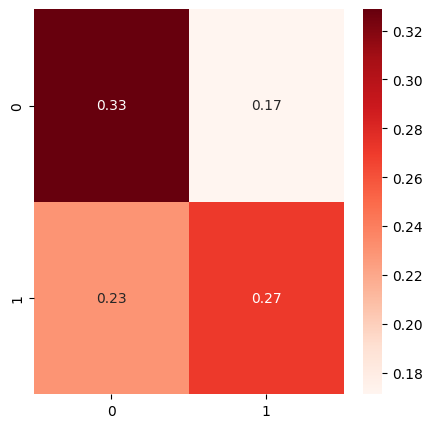

In [87]:
report(y_test, lgbm_best.predict(x_test_selected))

# Результаты

In [112]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [113]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [114]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [115]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.79 +- 0.03 , 'AUC': 0.87 +- 0.02 ,'Precision': 0.79 +- 0.03 ,'Recall': 0.74 +- 0.07 ,'F1-score': 0.74 +- 0.07 ,'F2-score': 0.75 +- 0.05
'Accuracy': 0.82 +- 0.05 , 'AUC': 0.89 +- 0.03 ,'Precision': 0.81 +- 0.05 ,'Recall': 0.82 +- 0.03 ,'F1-score': 0.8 +- 0.04 ,'F2-score': 0.81 +- 0.03
'Accuracy': 0.81 +- 0.03 , 'AUC': 0.89 +- 0.04 ,'Precision': 0.8 +- 0.04 ,'Recall': 0.78 +- 0.03 ,'F1-score': 0.78 +- 0.03 ,'F2-score': 0.79 +- 0.03
'Accuracy': 0.81 +- 0.03 , 'AUC': 0.88 +- 0.04 ,'Precision': 0.8 +- 0.05 ,'Recall': 0.78 +- 0.01 ,'F1-score': 0.78 +- 0.02 ,'F2-score': 0.78 +- 0.01
'Accuracy': 0.81 +- 0.03 , 'AUC': 0.89 +- 0.03 ,'Precision': 0.81 +- 0.04 ,'Recall': 0.8 +- 0.02 ,'F1-score': 0.79 +- 0.03 ,'F2-score': 0.8 +- 0.02


In [116]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test_selected, y_test))

{'Accuracy': 0.57, 'AUC': 0.57, 'Precision': 0.65, 'Recall': 0.32, 'F1-score': 0.43, 'F2-score': 0.36}
{'Accuracy': 0.55, 'AUC': 0.55, 'Precision': 0.53, 'Recall': 0.78, 'F1-score': 0.63, 'F2-score': 0.71}
{'Accuracy': 0.62, 'AUC': 0.62, 'Precision': 0.63, 'Recall': 0.62, 'F1-score': 0.62, 'F2-score': 0.62}
{'Accuracy': 0.6, 'AUC': 0.6, 'Precision': 0.61, 'Recall': 0.54, 'F1-score': 0.57, 'F2-score': 0.55}
{'Accuracy': 0.61, 'AUC': 0.61, 'Precision': 0.61, 'Recall': 0.61, 'F1-score': 0.61, 'F2-score': 0.61}


In [121]:
import shap
shap.initjs()

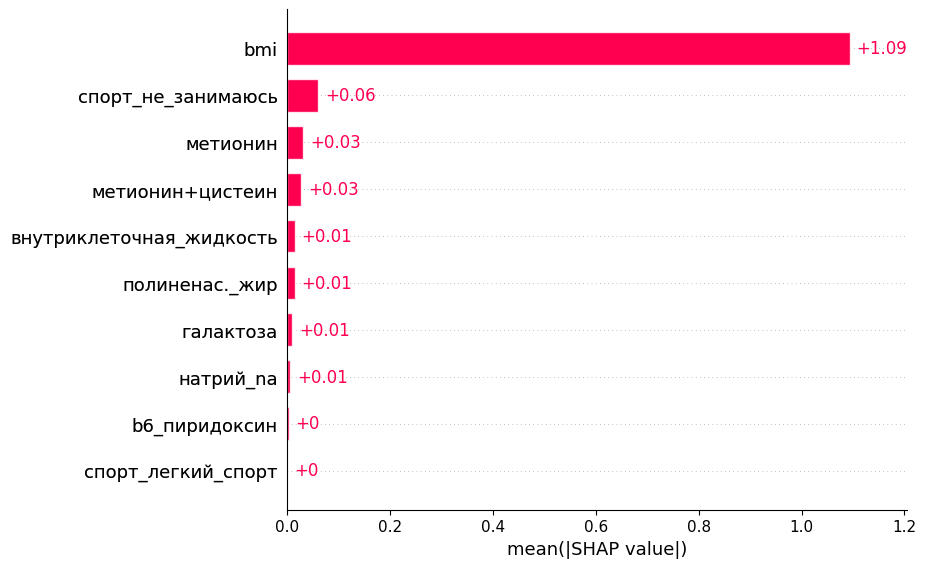

In [120]:
explainer = shap.TreeExplainer(xgb_rfc_best)
shap_values = explainer(x_train_selected)
shap.plots.bar(shap_values)

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor

In [94]:
estimator = Pipeline([("imputer", IterativeImputer(missing_values=np.nan)),
                      ("boosting", xgb_best)])

scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(estimator, x_train_selected, y_train, scoring=scoring)


metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
imputer_metrics = []
for metric in metrics: imputer_metrics.append(scores[metric])
imputer_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
imputer_metrics = np.array(imputer_metrics)

print("'Accuracy':", round(np.mean(imputer_metrics[0]), round_num),"+-",round(np.std(imputer_metrics[0]), round_num),",",
        "'AUC':", round(np.mean(imputer_metrics[1]), round_num),"+-",round(np.std(imputer_metrics[1]), round_num),","
        "'Precision':", round(np.mean(imputer_metrics[2]), round_num),"+-",round(np.std(imputer_metrics[2]), round_num),","
        "'Recall':", round(np.mean(imputer_metrics[3]), round_num),"+-",round(np.std(imputer_metrics[3]), round_num),","
        "'F1-score':", round(np.mean(imputer_metrics[4]), round_num),"+-",round(np.std(imputer_metrics[4]), round_num),","
        "'F2-score':", round(np.mean(imputer_metrics[5]), round_num),"+-",round(np.std(imputer_metrics[5]), round_num),)

[09:25:43] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:25:48] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:25:52] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:25:57] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[09:26:01] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

'Accuracy': 0.8 +- 0.01 , 'AUC': 0.86 +- 0.03 ,'Precision': 0.79 +- 0.03 ,'Recall': 0.76 +- 0.02 ,'F1-score': 0.77 +- 0.01 ,'F2-score': 0.77 +- 0.01
